In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False

from elderflower.task import Run_Detection, Match_Mask_Measure, Run_PSF_Fitting
from elderflower.plotting import AsinhNorm, LogNorm, colorbar

In [2]:
obj_name = 'NGC4013'
filt = 'g'

work_dir = '/Users/qliu/dragonfly/psf/NGC4013'
fn = '/Users/qliu/Data/fields/coadd_SloanG_NGC_4013.fits'

bounds = ((1900, 2700, 2600, 3400))

*Run_Detection* runs SExtractor to generate a catalog for crossmatch and a first segmentation map. A zero-point is computed using functions in dfreduce.catalogues, if ZP_keyname is not given in the fits header.

In [3]:
Run_Detection(fn, obj_name, filt,
              threshold=3, work_dir=work_dir,
              ZP_keyname='REFZP', ZP=None,
              executable='/opt/local/bin/source-extractor',
              config_path='default.sex')

Run SExtractor on /Users/qliu/Data/fields/coadd_SloanG_NGC_4013.fits...
Read zero-point from header : ZP = 27.116
CATALOG saved as /Users/qliu/dragonfly/psf/NGC4013/NGC4013.cat
SEGMENTATION saved as /Users/qliu/dragonfly/psf/NGC4013/NGC4013_seg.fits


*Match_Mask_Measure* does all the fussy work, including: crossmatch the field with APASS/PANSTARRS, calculate color correction, make up for unmatched stars by correcting saturation empirically, build a base mask map for dimmer stars.

Measure the intensity at R = 12 for stars < 15.0
            as normalization of fitting

Read Image : /Users/qliu/Data/fields/coadd_SloanG_NGC_4013.fits
BACKVAL: 519.18 +/- 4.85 , ZP: 27.12

Match field [50, 50, 5700, 4200] with catalog

Measure Sky Patch (X min, Y min, X max, Y max) :
[1900, 2700, 2600, 3400]


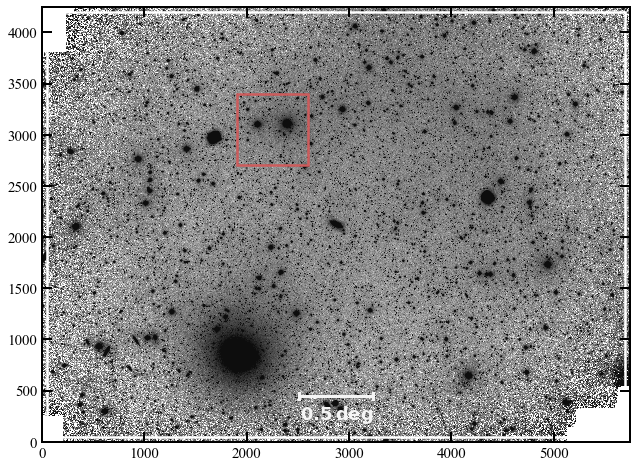

Search 2.434 deg around:
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (179.63035107, 43.94701389)>
Pan-STARRS rmag:  5.450 ~ 22.998
Pan-STARRS gmag:  7.512 ~ 28.291
Matched stars with Pan-STARRS gmag:  7.512 ~ 26.329
Matched bright stars with Pan-STARRS gmag:  7.512 ~ 14.998

Average Color Term [SE-catalog] = -0.12289


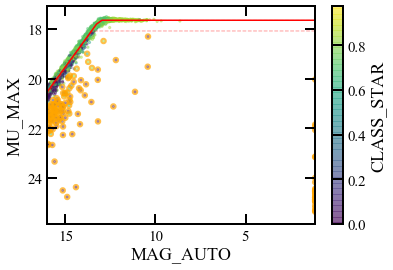

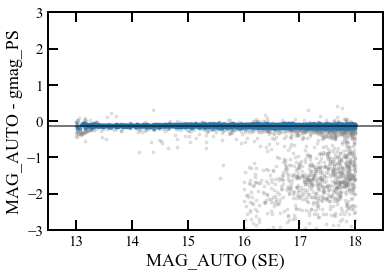

Mannually add unmatched bright stars to the catalog.


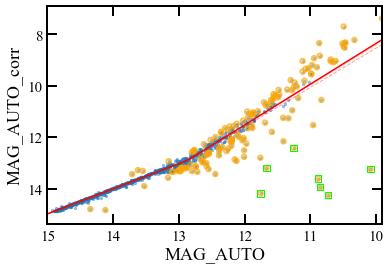

Save PANSTARRS catalog & matched sources in /Users/qliu/dragonfly/psf/NGC4013/Measure-PS1/

Fit 3-order empirical relation of aperture radii for catalog stars based on SE (X3.0)

Make segmentation map based on catalog gmag: 2589 stars


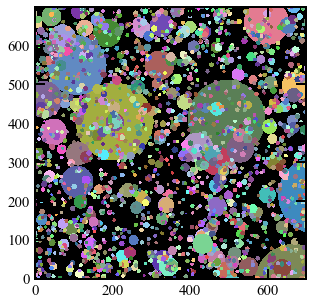

Save segmentation map made from catalog as /Users/qliu/dragonfly/psf/NGC4013/Measure-PS1/NGC4013-segm_gmag_catalog_X1900Y2700.fits

Measure intensity at R = 12
                for catalog stars gmag < 15.0 in array([1900, 2700, 2600, 3400]):
completed: 7/29
completed: 14/29
completed: 21/29
completed: 28/29
Save data to /Users/qliu/dragonfly/psf/NGC4013/Measure-PS1/NGC4013-thumbnail_gmag15_X1900Y2700.pkl


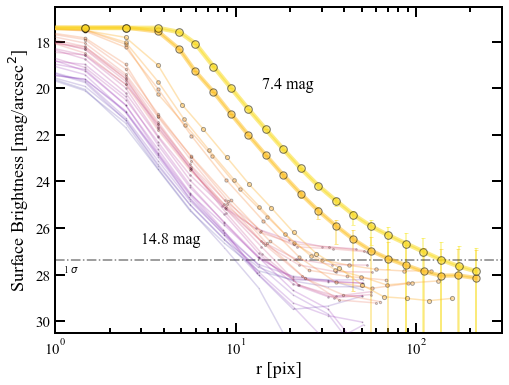

In [4]:
Match_Mask_Measure(fn, bounds, obj_name, band="G",
                   ZP=27.116, field_pad=50, pixel_scale=2.5,
                   use_PS1_DR2=False, work_dir=work_dir)

*Run_PSF_Fitting* does the actual fitting. It returns a list of "sampler" which contains all the fitting info

Magnitude Thresholds:  13.5, 10.5 mag
(<=> Flux Thresholds: 279511.71, 4429961.99 ADU)
# of medium bright (flux:2.9e+05~1.4e+06) stars: 12 
# of very bright (flux>5.8e+07) stars : 2
Not many bright stars, will draw in serial.

Read mask map built from catalog:  /Users/qliu/dragonfly/psf/NGC4013/Measure-PS1/NGC4013-segm_gmag_catalog_X1900Y2700.fits
Detect and deblend source... Mask S/N > 3.0 (3th enlarged)
Mask core regions: r < 24 (24) pix 


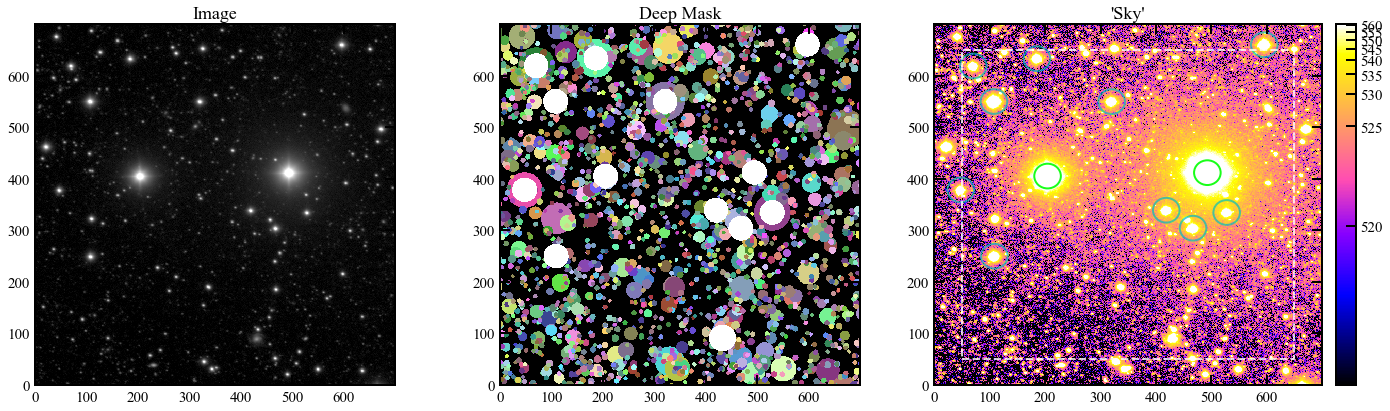

Use sky strips crossing very bright stars


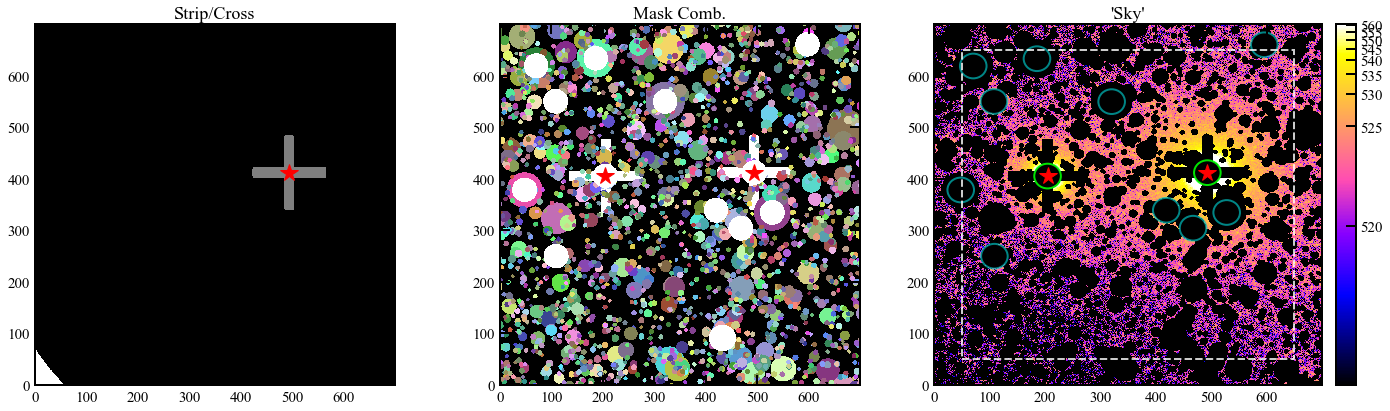

Is the Mask Reasonable?[y/n] y


Image[1900 2700 2600 3400]
Estimate of Background: (521.685 +/- 2.962)

Opening new pool: # of CPU used: 3


0it [00:00, ?it/s]

Run Nested Fitting for the image... Dim of params: 5


1762it [10:21,  2.83it/s, batch: 2 | bound: 66 | nc: 1 | ncall: 6637 | eff(%): 26.548 | loglstar: -395178.309 < -395174.549 < -395175.888 | logz: -395202.208 +/-  1.005 | stop:  6.603]   



Finish Fitting! Total time elapsed: 622 s

Pool Closed.


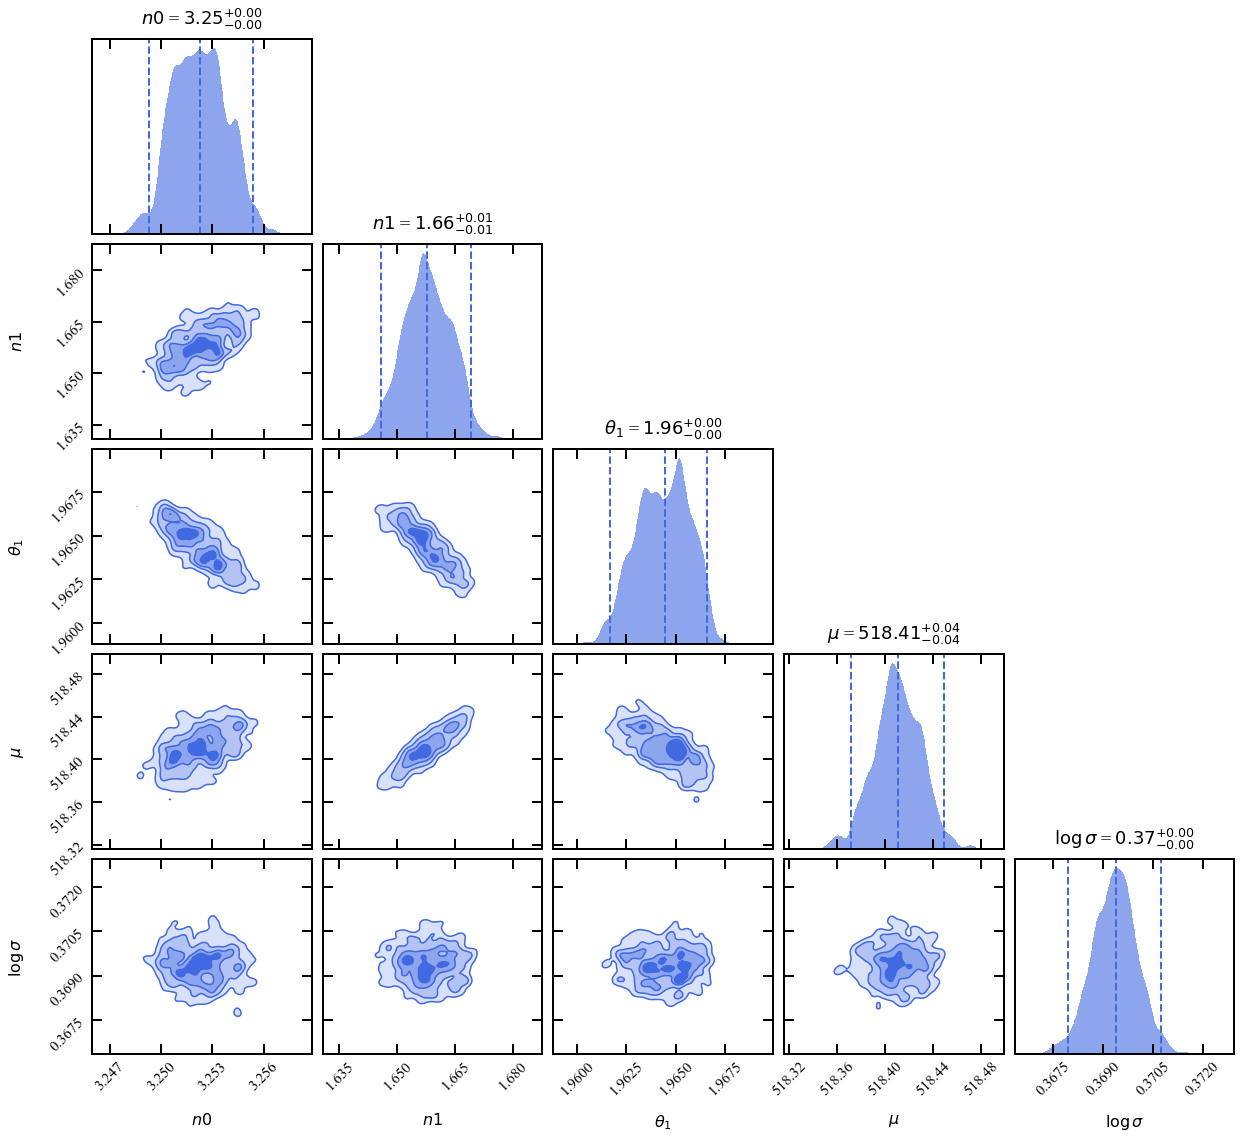

Fitting (mean) :  [3.2520e+00 1.6580e+00 1.9640e+00 5.1841e+02 3.6900e-01]
Fitting (median) :  [3.2520e+00 1.6580e+00 1.9640e+00 5.1841e+02 3.6900e-01]
Bakground : 518.41 +/- 2.34
Reduced Chi^2: 1.00106


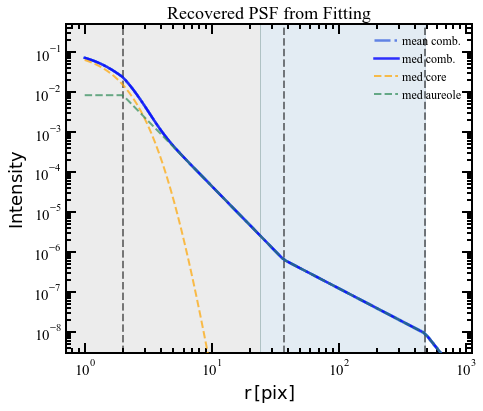

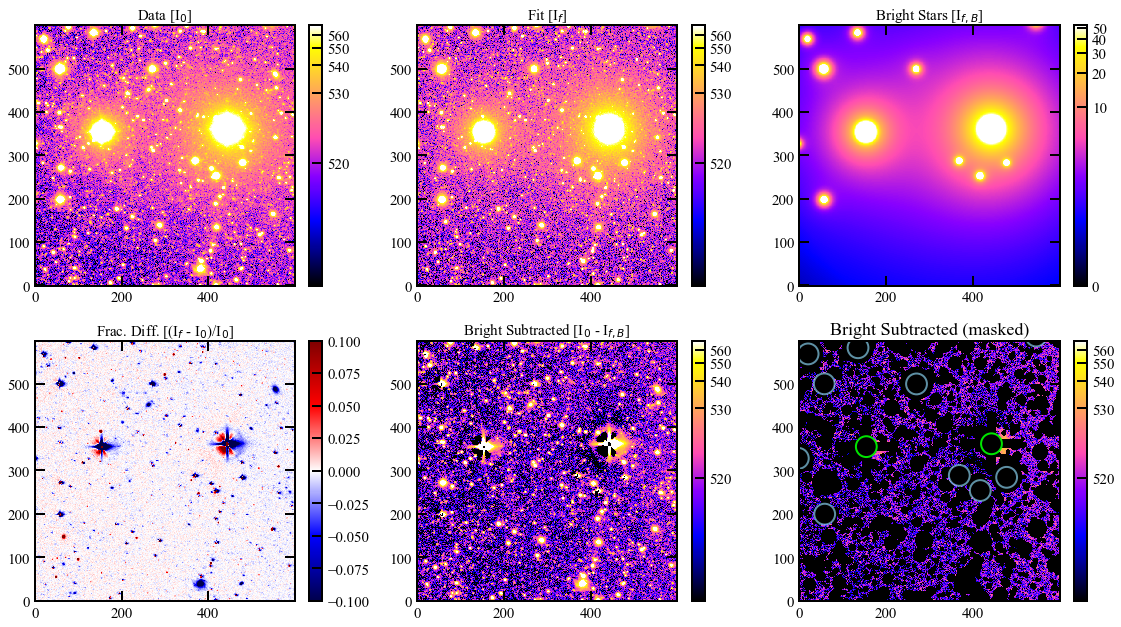

In [5]:
s = Run_PSF_Fitting(fn, bounds, obj_name, 
                    band="G", n_spline=2, n_cpu=4,
                    r_core=24, mag_threshold=[13.5,10.5],
                    ZP=27.116, pad=50, pixel_scale=2.5,
                    use_PS1_DR2=False, work_dir=work_dir)

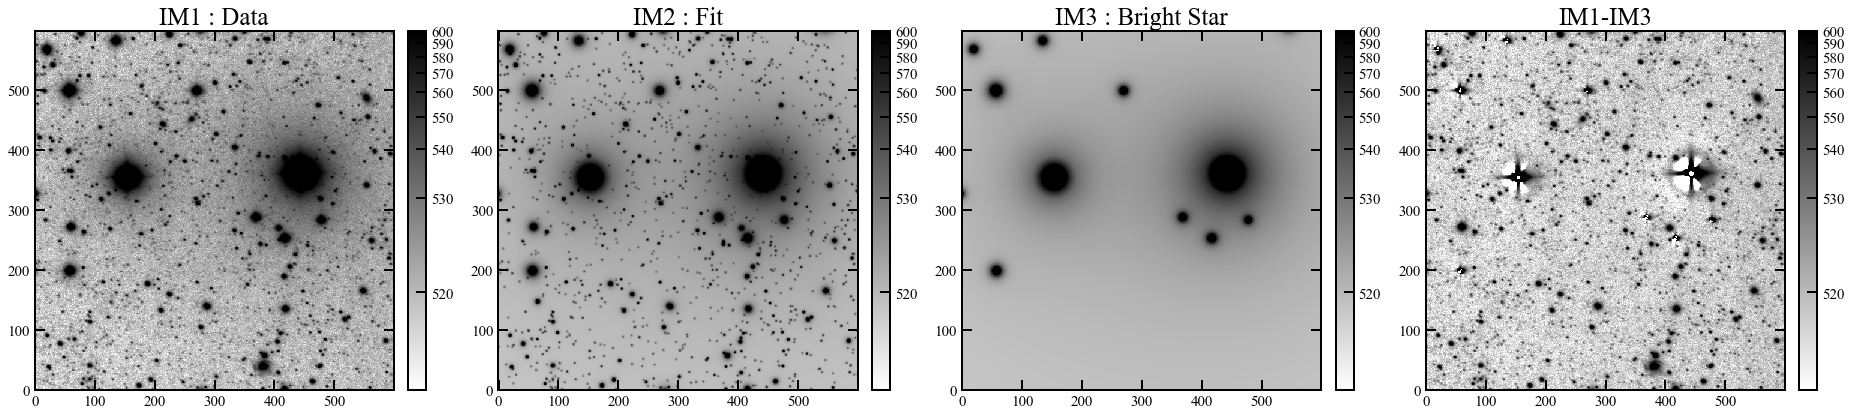

In [6]:
sampler = s[0]

fig, (ax1,ax2,ax3,ax4)=plt.subplots(1,4,figsize=(26,6))

m1=ax1.imshow(sampler.container.image,vmin=515, vmax=600, norm=AsinhNorm(0.05),cmap='gray_r')
m2=ax2.imshow(sampler.image_fit,vmin=515, vmax=600, norm=AsinhNorm(0.05),cmap='gray_r')
m3=ax3.imshow(sampler.image_star+sampler.bkg_fit,vmin=515, vmax=600, norm=AsinhNorm(0.05),cmap='gray_r')
m4=ax4.imshow(sampler.container.image-sampler.image_star,vmin=515, vmax=600, norm=AsinhNorm(0.05),cmap='gray_r')

ax1.set_title('IM1 : Data', fontsize=25)
ax2.set_title('IM2 : Fit', fontsize=25)
ax3.set_title('IM3 : Bright Star', fontsize=25)
ax4.set_title('IM1-IM3', fontsize=25)

for m in [m1,m2,m3,m4]:
    colorbar(m)
    
plt.tight_layout()